In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [3]:
# Import relevant libraries - ddg for importing images
from duckduckgo_search import ddg_images
from fastcore.all import *

# a function that returns image urls for search terms, we can control how many images we want
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('grizzly bear photos', max_images=1)

Searching for 'grizzly bear photos'


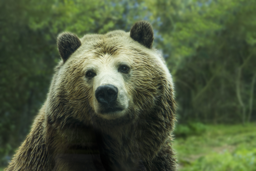

In [5]:
# Let's see what picture do we get for a grizzly bear 
from fastdownload import download_url
dest = 'grizzly.jpg'
download_url(urls[0], dest, show_progress=False) # downloads the url to destination (dest)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
# define three type of bears to search images and store in path
bear_types = 'teddy', 'black', 'grizzly'
path = Path('bears')

In [7]:
# Download and store images for different bears in respective folders
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results = search_images(f'{o} bear')
    download_images(dest, urls=results)

Searching for 'teddy bear'
Searching for 'black bear'
Searching for 'grizzly bear'


In [8]:
# check the path for our images
fns = get_image_files(path)
fns
# they exist in the folder!

(#87) [Path('bears/teddy/667719d0-be4c-4d71-ba60-12c05bb8c051.jpg'),Path('bears/teddy/e5e526b2-fe8b-49f2-b5c1-a28f958c8311.jpg'),Path('bears/teddy/2e3a75c6-57a0-4de8-9d94-ceccd5597855.jpg'),Path('bears/teddy/fb03bbfd-b8cc-4409-91d5-fb780cfb3c8d.jpg'),Path('bears/teddy/727f592e-1a5f-424a-a531-2e1b6fc77aab.jpg'),Path('bears/teddy/6eec079b-2849-44b0-a092-29a2b74d3474.jpg'),Path('bears/teddy/4d460e35-bb44-4abb-9ff2-f1ae4be1e7be.jpeg'),Path('bears/teddy/7cadfd7f-3967-4dd8-9119-3634522b311d.jpg'),Path('bears/teddy/b32ee4a9-e4e8-400d-99de-7e3da0aece43.jpg'),Path('bears/teddy/7091abe5-bdc3-4482-85d8-826b1ff5242e.jpg')...]

In [9]:
# check for images failed to download
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/e5e526b2-fe8b-49f2-b5c1-a28f958c8311.jpg')]

In [10]:
# remove failed images
failed.map(Path.unlink);

In [11]:
# DataBlock by fastai is an easy class to divide data into train and validation. Here we randomly divide the data - 80/20
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=20),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
# source of data or the path where images are
dls = bears.dataloaders(path)

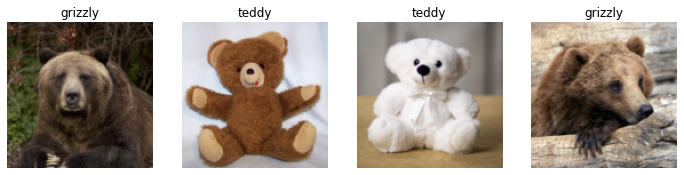

In [13]:
# check the images and labels trained by model
dls.valid.show_batch(max_n=4, nrows=1)

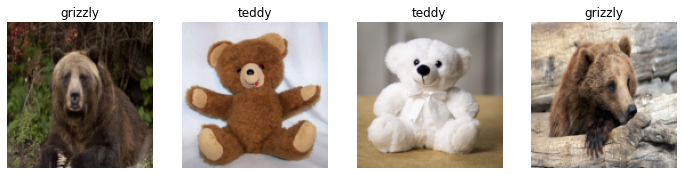

In [14]:
# cropping the image leads to important information being discarded
# Squish the images and see how they look - stretchy, so the model learns thigs not exactly as they appear
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

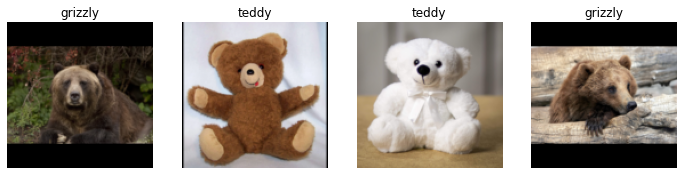

In [15]:
# Pad the images - a lot of empty space, wasted computatoin
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

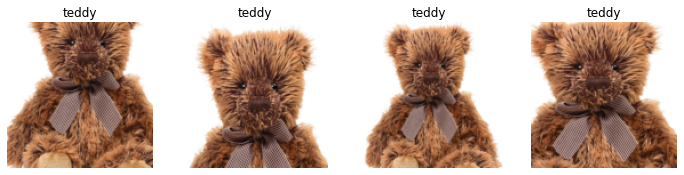

In [16]:
# Trying data augmentation techniques
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

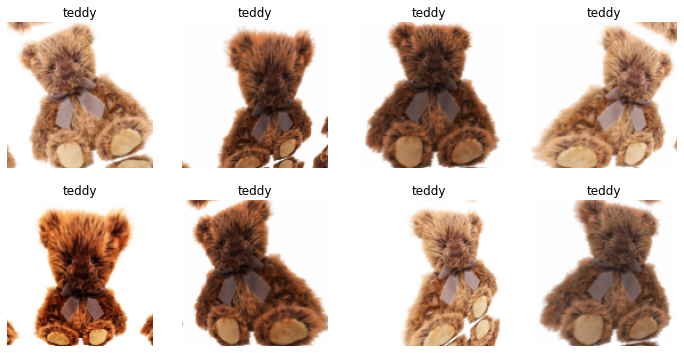

In [17]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
# Training the model and using it to clean the data
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.396923,6.233703,0.647059,00:22


epoch,train_loss,valid_loss,error_rate,time
0,2.021052,4.176787,0.647059,00:23
1,1.719927,2.008313,0.411765,00:22
2,1.334454,0.762874,0.294118,00:24
3,1.063073,0.345778,0.117647,00:24


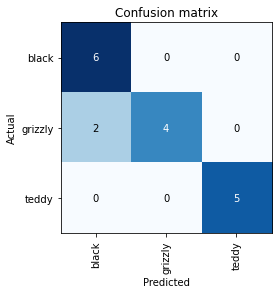

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

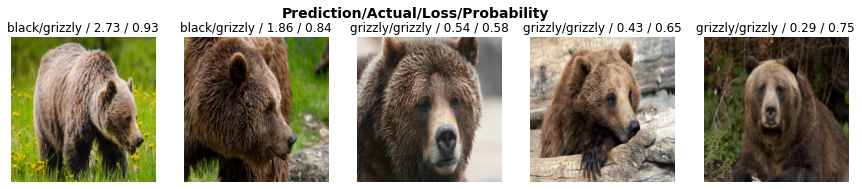

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
#hide_output
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner